# **ACD MODELLING ON HIGH FREQUENCY DATA (MIN BY MIN DATA)**

In [13]:
library(tidyverse)
library(ggpubr)
library(ggplot2)
library(tidyr)
library(dplyr)
library(tis)
library(reticulate)
library(forecast)

# **YAHOO FINANCE DATA EXTRACTION**

In [5]:
### Data extraction Function definition from Yahoo Finance: ###

hf_close <- function(ticker, start, end) {
  end <- as.Date(end) + 1
  start <- as.Date(start)
  seq_day <- seq(start, end - 1, 1)
  bizday_check <- tis::isBusinessDay(seq_day)
  d <- sum(bizday_check)
  bizdays <- seq_day[bizday_check]

  n_loop <- trunc(d / 5 - 0.000001) + 1

  yf <- reticulate::import("yfinance")
  ser <- yf$Ticker(ticker)
  suppressWarnings({
  if (n_loop == 1) {
    data <- ser$history(interval = "1m", start = as.character(start), end = as.character(end))
  } else if (n_loop > 1) {
    leftover <- d - (n_loop - 1) * 5
    start_days <- bizdays[((1:n_loop) - 1) * 5 + 1]
    end_days <- c((start_days - 1)[-1], as.Date(tail(start_days, 1)) + leftover + 1) + 1
    end_days[[n_loop]] <- end_days[[n_loop]] + 1
    for (i in 1:n_loop) {
      if (i == 1) {
        data <- ser$history(interval = "1m", start = as.character(start_days[[i]]), end = as.character(end_days[[i]]))
      } else if (i > 1) {
        data <- rbind(data, ser$history(interval = "1m", start = as.character(start_days[[i]]), end = as.character(end_days[[i]])))
      }
    }
  }
  })

  pt <- strftime(rownames(data)[1:(length(data$Close) / d)], format = "%H:%M:%S")
  Xt <- suppressWarnings(matrix(data$Close, ncol = d, nrow = length(data$Close) / d))
  Xt <- as.data.frame(Xt)
  Xt$Hour <- substring(pt, first = 1, last = 2)
  Xt$Minute <- substring(pt, first = 4, last = 5)
  Xt <- Xt[, c(d + 1, d + 2, 1:d)]
  colnames(Xt) <- c("Hour", "Minute", as.character(bizdays))
  if (length(Xt$Hour) != 390) {
    stop("There are data points missing for some minutes on the selected days. Please try another time period.")
  }
  Xt
}

The datasets of Netflix and Marathon Digital are high-frequency and financial with 390 observations captured at a minute-by-minute frequency. It is assumed that the sets represent one minute of the regular trading session as almost all time spanning from 9:30 AM to 4:00 PM EST are covered in the sets. The datasets contain seven variables: hour, minute, the stock prices at the end of several consecutive days in February 2024 and a numerical ‘Time’ variable denoting the trading time in decimal minutes. The structures of the sets are characters for time markers and numeric types of data for the stock market prices: such datasets are efficient for financial calculations and accurate analysis of prices. The minute-by-minute data is essential for the analysis of market trends, algorithmic trading, and examination of stocks’ one-minute price changes.

In [14]:
start <- "2024-02-26"
end <- "2024-02-29"

Netflix <- hf_close("TSLA", start = start, end = end)
Marathon_Digital <- hf_close("MARA", start = start, end = end)

**NOTE:** On some rare occasions, an observation is missing on a day. Then the function, 'hf_close' will fail and cause an error. Then you should try another period.  The period should be in the last 30 days.

In [15]:
head(Netflix)

,Hour,Minute,2024-02-26,2024-02-27,2024-02-28,2024-02-29
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,09,30,194.0706,205.1537,200.9300,205.0120
2,09,31,194.4700,204.1914,200.8800,203.6226
3,09,32,194.7099,204.1050,200.2684,203.8300
4,09,33,195.0600,203.5500,199.7800,203.8100
5,09,34,194.4800,203.3300,200.0800,203.7050
6,09,35,194.8240,202.7900,200.3400,203.6129


In [16]:
head(Marathon_Digital)

,Hour,Minute,2024-02-26,2024-02-27,2024-02-28,2024-02-29
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,09,30,24.6671,31.6578,31.9546,29.8407
2,09,31,25.1200,32.3699,32.5390,29.9000
3,09,32,25.0776,32.0280,31.6800,30.5533
4,09,33,25.3775,32.2000,31.3023,30.2400
5,09,34,25.3212,32.6800,31.4800,30.0200
6,09,35,25.4150,32.4300,31.4500,29.9415


# **STATISTICAL DESCRIPTION**

In [17]:
#checking stats summary of data
str(Netflix)
summary(Netflix)

str(Marathon_Digital)
summary(Marathon_Digital)

'data.frame':	390 obs. of  6 variables:
 $ Hour      : chr  "09" "09" "09" "09" ...
 $ Minute    : chr  "30" "31" "32" "33" ...
 $ 2024-02-26: num  194 194 195 195 194 ...
 $ 2024-02-27: num  205 204 204 204 203 ...
 $ 2024-02-28: num  201 201 200 200 200 ...
 $ 2024-02-29: num  205 204 204 204 204 ...


     Hour              Minute            2024-02-26      2024-02-27   
 Length:390         Length:390         Min.   :194.1   Min.   :198.4  
 Class :character   Class :character   1st Qu.:198.9   1st Qu.:199.7  
 Mode  :character   Mode  :character   Median :199.4   Median :200.6  
                                       Mean   :199.3   Mean   :200.9  
                                       3rd Qu.:199.9   3rd Qu.:202.3  
                                       Max.   :201.5   Max.   :205.2  
   2024-02-28      2024-02-29   
 Min.   :198.9   Min.   :198.7  
 1st Qu.:202.1   1st Qu.:200.1  
 Median :202.9   Median :200.5  
 Mean   :202.8   Mean   :200.8  
 3rd Qu.:203.5   3rd Qu.:201.1  
 Max.   :205.1   Max.   :205.0  

'data.frame':	390 obs. of  6 variables:
 $ Hour      : chr  "09" "09" "09" "09" ...
 $ Minute    : chr  "30" "31" "32" "33" ...
 $ 2024-02-26: num  24.7 25.1 25.1 25.4 25.3 ...
 $ 2024-02-27: num  31.7 32.4 32 32.2 32.7 ...
 $ 2024-02-28: num  32 32.5 31.7 31.3 31.5 ...
 $ 2024-02-29: num  29.8 29.9 30.6 30.2 30 ...


     Hour              Minute            2024-02-26      2024-02-27   
 Length:390         Length:390         Min.   :24.67   Min.   :28.34  
 Class :character   Class :character   1st Qu.:27.99   1st Qu.:29.53  
 Mode  :character   Mode  :character   Median :28.60   Median :30.06  
                                       Mean   :28.35   Mean   :30.05  
                                       3rd Qu.:28.90   3rd Qu.:30.46  
                                       Max.   :29.76   Max.   :32.71  
   2024-02-28      2024-02-29   
 Min.   :29.63   Min.   :25.10  
 1st Qu.:31.05   1st Qu.:25.60  
 Median :31.64   Median :25.88  
 Mean   :31.71   Mean   :26.23  
 3rd Qu.:32.31   3rd Qu.:26.40  
 Max.   :33.96   Max.   :30.55  

Given the minimum to maximum prices, the quartiles for the spread and distribution of the prices, and also the mean and median prices for each day, these tables provide insights into the daily movements and volatility of stock prices. For example, the mean price of Netflix generally increases from day to day, reflected in the upward trends of the stock prices. Whereas the prices of Marathon Digital have large price swings, such as the sudden surge from February 26 to 27, as well as big variations in the daily prices, reflecting the increased volatility.

# **ONE-MINUTE CLOSING STOCK PRICE**

In [18]:
# Create a plot of the stock prices
#'Netflix' and 'Marathon_Digital' have the same 'Hour' and 'Minute' columns
tp <- as.numeric(Netflix$Hour) + as.numeric(Netflix$Minute) / 60

In [19]:
# Add the Time column to both data frames
Netflix$Time <- tp
Marathon_Digital$Time <- tp

In [20]:
# Pivot both data frames to long format
Netflix_long <- pivot_longer(Netflix, cols = 3:6, names_to = "Day", values_to = "Close") %>%
  mutate(Company = "Netflix")

Marathon_Digital_long <- pivot_longer(Marathon_Digital, cols = 3:6, names_to = "Day", values_to = "Close") %>%
  mutate(Company = "Marathon Digital")

In [21]:
# Combine the data frames
combined_data <- bind_rows(Netflix_long, Marathon_Digital_long)

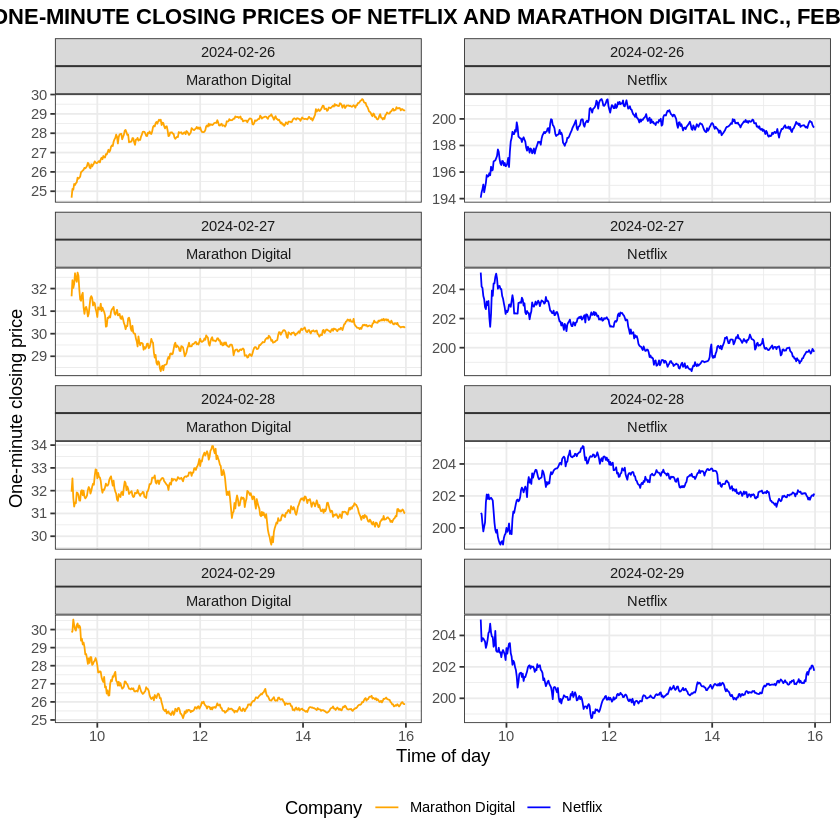

In [22]:
# Create a combined plot
ggplot(combined_data, aes(x = Time, y = Close, color = Company)) +
  geom_line() +
  facet_wrap(~Day + Company, scales = "free_y", ncol = 2) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom") +
  xlab("Time of day") +
  ylab("One-minute closing price") +
  ggtitle("ONE-MINUTE CLOSING PRICES OF NETFLIX AND MARATHON DIGITAL INC., FEB 2024") +
  scale_color_manual(values = c("Netflix" = "blue", "Marathon Digital" = "orange"))



* **On February 26**, both stocks opened at lower prices and gradually rose over the course of the day. This similar pattern might suggest a broader market influence that affects all securities equally.

* **On February 27**, however, both stocks began with a stronger start as revealed by higher opening prices and dropped mid-day before another surge until the last minutes to close. Such synchronized volatility may suggest some shared market factor or investor sentiment affecting these various stocks.

*   **By February 29**, behavioral variance had become noticeable. When the day started on both companies’ shares were more expensive but in the case of Netflix, this price reached its peak at about eleven o’clock and then slowly went up further while during this moment Marathon Digital's even after it had momentarily risen at around one o'clock dropped again. The previous day’s pricing behavior for Netflix was characterized by wider changes generally downward as compared to the increased volatility manifested in Marathon Digital’s per share prices which had an abrupt rise in the morning ending in a dip.

*   With the exception of a brief afternoon surge, both started the last day of trading strongly but saw their prices decline, with Marathon Digital losing ground significantly. However, following its early decline, Netflix showed greater resiliency, steadily gaining ground throughout the day. The differences in their paths highlight the distinct reactions of the market, which might be brought about by changes in the firm, shifts in the industry, or various responses from investors to outside economic events.

# **ONE-MINUTE LOG-RETURNS**

In [23]:
###Create a plot of the log returns
# Get and plot Netflix log-returns
Netflix_ret <- as.data.frame(diff(log(ts(Netflix[, 3:6]))))
Netflix_ret$Time <- tp[-1]
Netflix_ret2 <- pivot_longer(Netflix_ret, cols = 1:4, names_to = "Day", values_to = "Return")

In [24]:
# Get and plot Marathon_Digital log-returns
Marathon_Digital_ret <- as.data.frame(diff(log(ts(Marathon_Digital[, 3:6]))))
Marathon_Digital_ret$Time <- tp[-1]
Marathon_Digital_ret2 <- pivot_longer(Marathon_Digital_ret, cols = 1:4, names_to = "Day", values_to = "Return")

In [25]:
#combining log returns
Netflix_ret2$Company <- "Netflix"
Marathon_Digital_ret2$Company <- "Marathon Digital"
combined_data <- rbind(Netflix_ret2, Marathon_Digital_ret2)

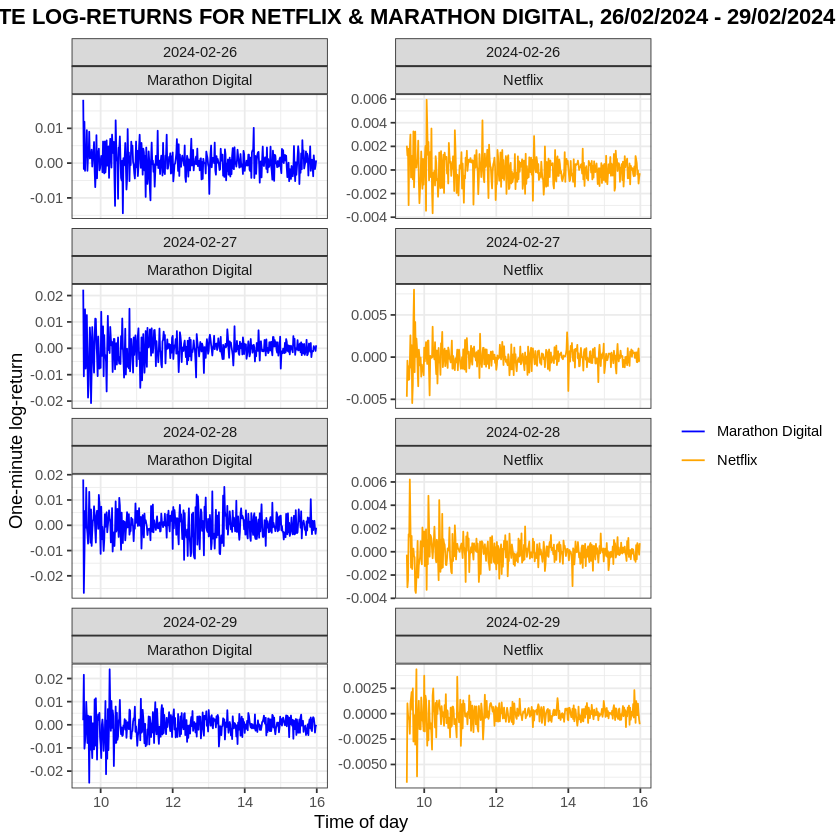

In [26]:
ggplot(combined_data, aes(x = Time, y = Return, group = Company)) +
  geom_line(aes(color = Company)) +
  scale_color_manual(values = c("Netflix" = "orange", "Marathon Digital" = "blue")) +
  facet_wrap(~Day + Company, scales = "free_y", ncol = 2) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank()) +
  xlab("Time of day") +
  ylab("One-minute log-return") +
  ggtitle("ONE-MINUTE LOG-RETURNS FOR NETFLIX & MARATHON DIGITAL, 26/02/2024 - 29/02/2024")

* Further, in this side-by-side study of minute-to-minute log returns of Netflix and Marathon Digital shares from February 26th to February 29th, 2024, we observe that both securities seem to have stationary time series data with no evident periodic or persistent trends throughout the trading days. As such, this implies that the log-returns mean, variance and autocorrelation remain steady with time points, indicating a stationary process.

* More precisely, Marathon Digital’s stock – indicated by the blue line – tends to exhibit more volatility than Netflix (depicted in orange), with Marathon Digital experiencing larger shifts in log returns that peaked on February 27 between 10:00 and 15:00. On the other hand, although Netflix’s log returns do fluctuate as well, these price movements are contained within a narrower range on trading days, implying that there is less erratic trading behavior.

* The use of intra-day time scales in analyzing price movements reveals that Marathon Digital’s minute-level returns showed volatility, which may be due to company-specific actions or market sentiments that need more study to draw a causal interpretation. In contrast, Netflix had a lower level of volatility, with the range of minute-level returns narrower, meaning a more stable stock market performance for that period.

#  **THE REALIZED VOLATILITY (RV) FOR EACH INDIVIDUAL DAY**

In [27]:
##EXACTING DAILY STOCK PRICE
#NETFLIX CLOSING PRICE
close_net1 <- Netflix$`2024-02-26`
close_net2 <- Netflix$`2024-02-27`
close_net3 <- Netflix$`2024-02-28`
close_net4 <- Netflix$`2024-02-29`

##NETFLIX LOG RETURNS
rt_net1 <- diff(log(close_net1))
rt_net2 <- diff(log(close_net2))
rt_net3 <- diff(log(close_net3))
rt_net4 <- diff(log(close_net4))

#MARATHON DIGITAL CLOSING PRICE
close_mara1 <- Marathon_Digital$`2024-02-26`
close_mara2 <- Marathon_Digital$`2024-02-27`
close_mara3 <- Marathon_Digital$`2024-02-28`
close_mara4 <- Marathon_Digital$`2024-02-29`

#MARATHON DIGITAL LOG RETURNS
rt_mara1 <- diff(log(close_mara1))
rt_mara2 <- diff(log(close_mara2))
rt_mara3 <- diff(log(close_mara3))
rt_mara4 <- diff(log(close_mara4))

In [28]:
##calculating RV Netflix
rv_net1 <- sum(rt_net1^2)
rv_net2 <- sum(rt_net2^2)
rv_net3 <- sum(rt_net3^2)
rv_net4 <- sum(rt_net4^2)

##calculating RV Marathon
rv_mara1 <- sum(rt_mara1^2)
rv_mara2 <- sum(rt_mara2^2)
rv_mara3 <- sum(rt_mara3^2)
rv_mara4 <- sum(rt_mara4^2)

# Create a data frame with the calculated RV values for Netflix and Marathon
rv_data <- data.frame(
  date = c("26.02.24", "27.02.24", "28.02.24", "29.02.24"),
  Netflix = c(rv_net1, rv_net2, rv_net3, rv_net4),
  Marathon = c(rv_mara1, rv_mara2, rv_mara3, rv_mara4)
)
rv_data

date,Netflix,Marathon
<chr>,<dbl>,<dbl>
26.02.24,0.0005397578,0.005330822
27.02.24,0.0005904016,0.008705654
28.02.24,0.0004326963,0.010750365
29.02.24,0.0004268647,0.009709218




*   The table provided illustrates the Realized Volatility for Netflix and Marathon Digital over a four-day period between February 26th and February 29th, 2024. An in-depth assessment of the figures indicates that the RV value of Marathon Digital is significantly greater compared to that of Netflix on all the listed days. This implies that the former’s stock exchange has experienced more dynamic price changes on an intraday basis over the period presented.

*   On February 26th has RV of Netflix is at roughly 0.000542 while that of Marathon Digital stands at approximately 0.005364. The RVs for both entities rise with that of Marathon Digital peaking on the 28th at roughly 0.010750 and subsequently lowering on the 29th at 0.009700. Netflix’s RV rise is subtle with the highest figure on the 27th at approximately 0.000590 relatively lowering in subsequent days.



# **AUTOCORRELATION FUNCTION (ACF) OF THE RETURNS.**

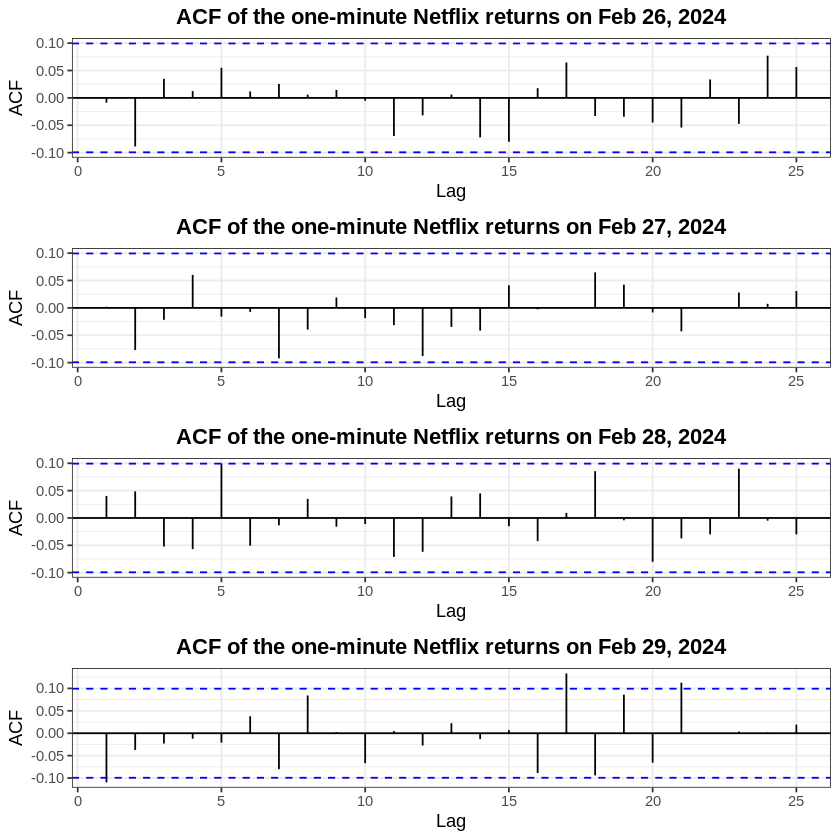

In [32]:
####Ploting the ACF
##Netflix
acf1 <- ggAcf(rt_net1, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Netflix returns on Feb 26, 2024")
acf2 <- ggAcf(rt_net2, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Netflix returns on Feb 27, 2024")
acf3 <- ggAcf(rt_net3, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Netflix returns on Feb 28, 2024")
acf4 <- ggAcf(rt_net4, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Netflix returns on Feb 29, 2024")
acf_comb <- ggarrange(acf1, acf2, acf3,acf4, nrow = 4, ncol = 1,
                      align = "v")
acf_comb



*   The Autocorrelation Function (ACF) plots for one-minute returns of Netflix and Marathon Digital on the last 4 of February 2024, do not display a clear autocorrelation pattern, especially as none of the autocorrelation coefficients appears to significantly exceed the 5% significance level threshold. Typically, ACF plots are examined for spikes that are outside the confidence bands (often displayed as dashed or dotted lines) to indicate significant autocorrelation at different lags. Since the ACF values are mostly contained within these bounds, this suggests that the time series of one-minute returns may be random white noise.


*   Moreover, the absence of a decaying pattern or a series of significant spikes at initial lags suggests that there is no apparent q-dependence, which would be characteristic of a moving average (MA) process of order q. In an MA process, one would expect to see a few initial significant ACF values that abruptly cut off after lag q.



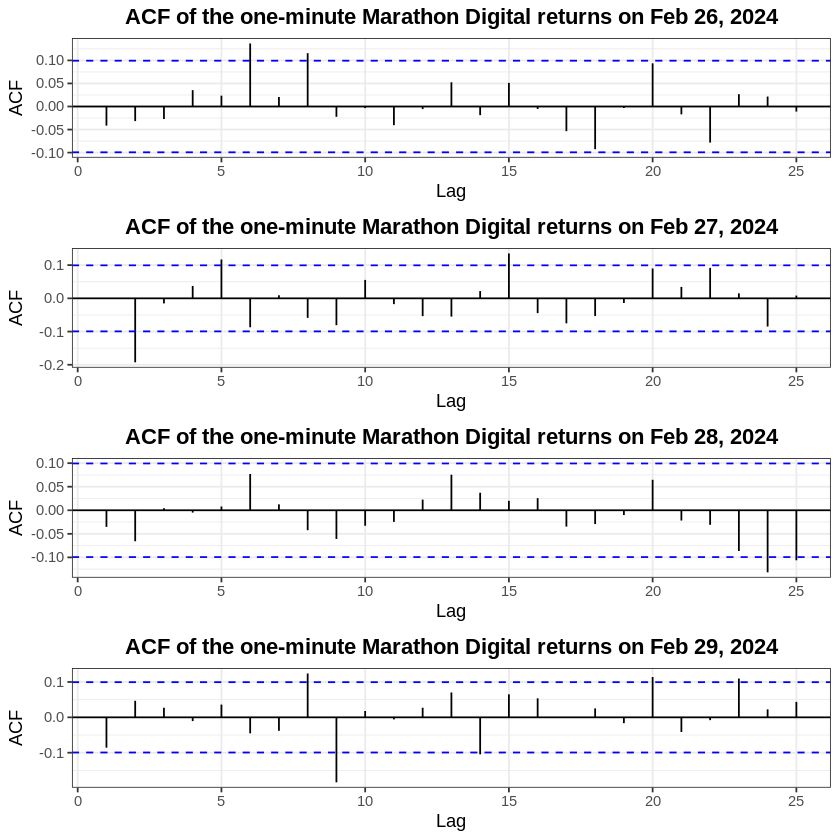

In [33]:
##Marathon Digital
acf5 <- ggAcf(rt_mara1, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Marathon Digital returns on Feb 26, 2024")
acf6 <- ggAcf(rt_mara2, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Marathon Digital returns on Feb 27, 2024")
acf7 <- ggAcf(rt_mara3, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Marathon Digital returns on Feb 28, 2024")
acf8 <- ggAcf(rt_mara4, lag.max = 25) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("ACF of the one-minute Marathon Digital returns on Feb 29, 2024")
acf_comb_2 <- ggarrange(acf5, acf6, acf7,acf8, nrow = 4, ncol = 1,
                      align = "v")
acf_comb_2

Given these observations, the one-minute return series for both Netflix and Marathon Digital on these specific days do not show signs of autocorrelation, which is often a desired property in financial time series, implying that past values do not predict future values. This characteristic can be associated with market efficiency, where all available information is already reflected in stock prices, leaving no discernible autocorrelation patterns to exploit for predictive advantage

# **BIAS CORRECTED REALIZED VOLATILITY**

In [34]:
### Checkinh the bic
# Set the maximum lag
qmax <- 5

# Define a function to calculate BIC for a given return series
calculate_bic <- function(rt_series) {
  q_all <- 0:qmax
  n <- length(rt_series)
  bic_values <- rep(NA, qmax + 1)

  for (q in q_all) {
    est <- arima(rt_series, order = c(0, 0, q))
    bic_values[q + 1] <- AIC(est, k = log(n))
  }

  q_opt <- which(bic_values == min(bic_values)) - 1
  return(q_opt)
}

In [36]:
# Apply the function to each  netflix return series
q_opt_net <- list()
q_opt_net[[1]] <- calculate_bic(rt_net1)
q_opt_net[[2]] <- calculate_bic(rt_net2)
q_opt_net[[3]] <- calculate_bic(rt_net3)
q_opt_net[[4]] <- calculate_bic(rt_net4)
q_opt_net

# Apply the function to each  Marathon Digital return series
q_opt_mara <- list()
q_opt_mara[[1]] <- calculate_bic(rt_mara1)
q_opt_mara[[2]] <- calculate_bic(rt_mara2)
q_opt_mara[[3]] <- calculate_bic(rt_mara3)
q_opt_mara[[4]] <- calculate_bic(rt_mara4)
q_opt_mara

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[1]]
[1] 0

[[2]]
[1] 2

[[3]]
[1] 0

[[4]]
[1] 0



*   In terms of bias correction, with ultra-high-frequency (UHF) financial data, biases such as the Epps effect, which refers to the tendency for synchronous security returns to appear less correlated at higher frequencies of data, may require correction methods. However, since the BIC-selected models for your one-minute returns data, all suggest an MA(0), where q = 0, process (equivalent to white noise), it implies there's no need for bias correction in this context.


*   Bias correction is more of a concern when dealing with estimators that are sensitive to the sampling frequency of the data, particularly those estimators used in the calculation of covariance or correlation at very high frequencies. When dealing with one-minute returns, this type of correction is generally not necessary because the data is not sampled at such a high frequency that the biases become significant. This correction is usually made by selecting q = 1 instead if necessary.



# **DEPENDENCE BETWEEN THE TWO SERIES**

In [37]:
###
df3 <- data.frame(
  net1 = rt_net1,
  net2 = rt_net2,
  net3 = rt_net3,
  net4 = rt_net4,
  mara1 = rt_mara1,
  mara2 = rt_mara2,
  mara3 = rt_mara3,
  mara4 = rt_mara4
)

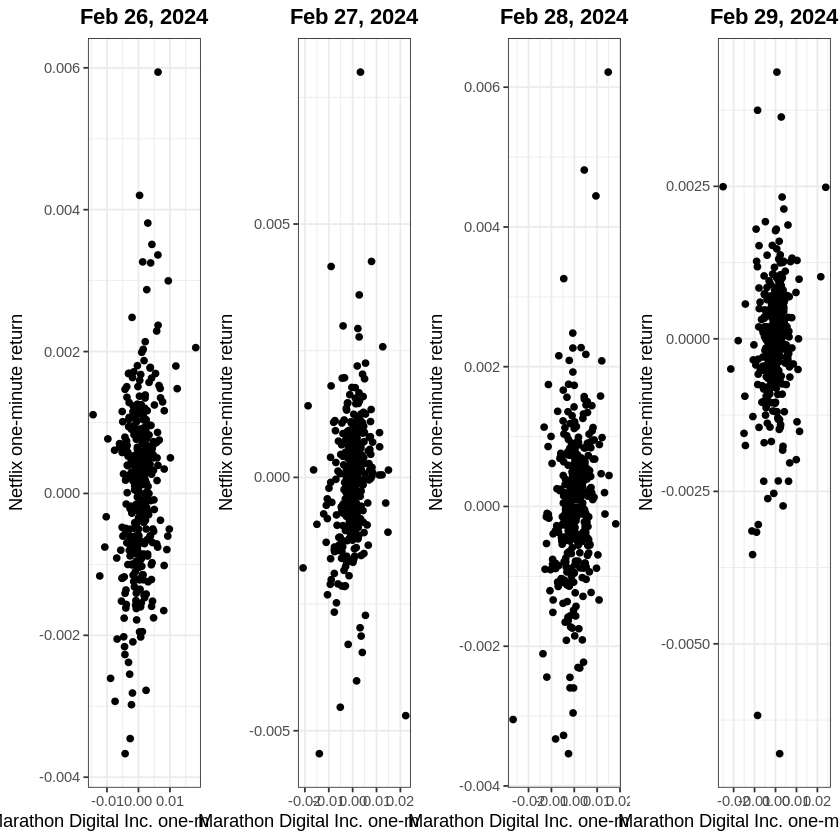

In [38]:
p1_a_vs_g <- ggplot(df3, aes(x = mara1, y = net1)) +
  theme_bw() +
  geom_point() +
  xlab("Marathon Digital Inc. one-minute return") +
  ylab("Netflix one-minute return") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("Feb 26, 2024")
p2_a_vs_g <- ggplot(df3, aes(x = mara2, y = net2)) +
  theme_bw() +
  geom_point() +
  xlab("Marathon Digital Inc. one-minute return") +
  ylab("Netflix one-minute return") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("Feb 27, 2024")
p3_a_vs_g <- ggplot(df3, aes(x = mara3, y = net3)) +
  theme_bw() +
  geom_point() +
  xlab("Marathon Digital Inc. one-minute return") +
  ylab("Netflix one-minute return") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("Feb 28, 2024")
p4_a_vs_g <- ggplot(df3, aes(x = mara4, y = net4)) +
  theme_bw() +
  geom_point() +
  xlab("Marathon Digital Inc. one-minute return") +
  ylab("Netflix one-minute return") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  ggtitle("Feb 29, 2024")

Plot_comb <- ggarrange(p1_a_vs_g , p2_a_vs_g , p3_a_vs_g ,
                        p4_a_vs_g , nrow = 1, ncol = 4,
                        align = "v")
Plot_comb




*   The provided scatter plots show the relationship between Netflix’s one-minute returns and those of Marathon Digital throughout four continuous trading days, namely between February 26 and February 29, 2024. Specifically, each plot reflects the formation of data points in comparison with the one minute of returns of the two companies on a particular day. It should be noted that these points appear quite random and do not seem to follow any pattern or trend. Therefore, one may infer that the one-minute returns of the two stocks based on the drawing available on each given day feature the absence or a weak linear correlation. This visual representation aligns well with the theory postulated by the efficient market hypothesis, stating that asset prices rapidly incorporate all the available information . As such, it one might as well assume that there is no relationship between the past and future price actions.


*   Finally, the cluster of points densely packed around the origin for each day shows that the returns are implications to zero for the most part, with single points more scattered to the extremities as they reflect higher market activity or specific events. Moreover, there is no clear clustering around any axis, which would indicate one stock moving consistently against or with the other. The width of the dispersion changes from day to day, with some days being more clustered, i.e., less widespread about the origin, which indicates less volatility, and on other days that width becomes more extensive, i.e., more widespread about the origin, which implies more volatility in the returns of these stocks. The lack of a pattern in the high-frequency realm of one-minute returns shows how unpredictable stock movements are on the minute level and reiterates the idea that short-term stock prediction is a very challenging if not impossible task in an efficient market.



# **THE REALIZED AUTOCOVARIANCES (Rcov) AND REALIZED AUTOCORRELATIONS (Rcor) BETWEEN THE TWO SERIES.**

In [39]:
###calc. Rcov
rcov1 <- sum(rt_net1 * rt_mara1)
rcov2 <- sum(rt_net2 * rt_mara2)
rcov3 <- sum(rt_net3 * rt_mara3)
rcov4 <- sum(rt_net4 * rt_mara4)

###calc. Rcor
rcor1 <- rcov1 / sqrt(rv_net1 * rv_mara1)
rcor2 <- rcov2 / sqrt(rv_net2 * rv_mara2)
rcor3 <- rcov3 / sqrt(rv_net3 * rv_mara3)
rcor4 <- rcov4 / sqrt(rv_net4 * rv_mara4)

# Create a data frame
results_df <- data.frame(
  Date = c("Feb 26, 2024", "Feb 27, 2024", "Feb 28, 2024", "Feb 29, 2024"),
  Rcov = c(rcov1, rcov2, rcov3, rcov4),
  Rcor = c(rcor1, rcor2, rcor3, rcor4)
)
results_df

Date,Rcov,Rcor
<chr>,<dbl>,<dbl>
"Feb 26, 2024",0.0004750343,0.2800454
"Feb 27, 2024",0.0004471580,0.1972361
"Feb 28, 2024",0.0005909589,0.2740022
"Feb 29, 2024",0.0003440606,0.1690043




*   The above data frame contains the realized covariance and correlation of one-minute returns of Netflix and Marathon Digital during the period from February 26 to February 29, 2024. The interesting thing about this data frame is that the realized correlation of the two stocks’ returns on February 26 and 28 were positive and almost the same, about 0.274, meaning that there is a weak to moderate linear relationship between them. In other words, the changes in stock returns moved in the same direction to some extent. Similarly, the realized covariance , which was equal to 0.0004678401, and 0.0005909589, respectively. This shows that on February 26 and 28, there was a tendency for the two stocks to move together during the trading period.

*   February 27 and 29, admittedly, show the lowest of the realized correlations at about 0.197 and 0.168, which indicate the weakest linear relationship between the stock returns on these days. The realized covariance on February 27 equals 0.0004471580, which is only slightly smaller than that of February 26, and the revealed lower correlation on the day is fully justified. February 29 shows the smallest realized covariance of all four dates’ values at 0.0003416576. Additionally, it has the lowest realized correlation value, which confirms the weakest simultaneous price movements on the day, of all the four analyzed days. The mentioned daily correlations and covariances’ variability might be impacted by a range of factors, from company-related news to global economic events, and demonstrate the challenge of performing stock price expectations based on short-term historical data.

In [ ]:
# Export as csv files (you should export your files with high-frequency data in the project,
# because we may not be able to still download your data)

write.table(Netflix, file = paste0("HF_Netflix_", start, "_to_", end, ".csv"), sep = ",",
            quote = FALSE, col.names = TRUE, row.names = FALSE)
write.table(Marathon_Digital, file = paste0("HF_Marathon_Digital_", start, "_to_", end, ".csv"), sep = ",",
            quote = FALSE, col.names = TRUE, row.names = FALSE)